# Activation

## Fake data

In [2]:
import pandas as pd
import numpy as np
from faker import Faker
from scipy.stats import poisson, gamma, bernoulli, expon

def create_fake_data(num_customers=100, start_date='2020-01-01', end_date='2024-01-01'):
    fake = Faker()
    Faker.seed(42)
    np.random.seed(42)
    
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    customer_ids = [fake.uuid4() for _ in range(num_customers)]
    
    data = []
    
    # Parameters for Poisson emissions from Gamma distributions for unactivated and activated states
    unactivated_params = {'shape': 2, 'rate': 0.5}
    activated_params = {'shape': 20, 'rate': 0.2}
    
    # Transition probabilities
    transition_matrix = np.array([[0.9, 0.1], [0.1, 0.9]])
    
    # Mean time to conversion in days
    mean_time_to_convert = 14
    
    for customer_id in customer_ids:
        workspace_creation_date = pd.Timestamp(fake.date_between(start_date=start_date, end_date=end_date))
        churn_date = workspace_creation_date + pd.Timedelta(days=np.random.randint(30, 365*2))  # Churn between 1 month and 2 years
        
        # Determine if and when the customer converts
        converts = bernoulli.rvs(0.04)
        if converts:
            # Time to conversion follows an exponential distribution
            time_to_convert = int(expon.rvs(scale=mean_time_to_convert))
            conversion_date = workspace_creation_date + pd.Timedelta(days=time_to_convert)
            if conversion_date > churn_date:
                conversion_date = churn_date
        else:
            conversion_date = None
        
        current_state = 0  # Start in the unactivated state
        
        for single_date in pd.date_range(start=workspace_creation_date, end=churn_date):
            features = []
            
            if current_state == 0:
                # Emissions for the unactivated state
                for _ in range(10):
                    lam = gamma.rvs(a=unactivated_params['shape'], scale=1/unactivated_params['rate'])
                    features.append(poisson.rvs(lam))
            else:
                # Emissions for the activated state
                for _ in range(10):
                    lam = gamma.rvs(a=activated_params['shape'], scale=1/activated_params['rate'])
                    features.append(poisson.rvs(lam))
            
            # Transition to the next state
            current_state = np.random.choice([0, 1], p=transition_matrix[current_state])
            
            dim_1 = fake.random_int(min=1, max=5)
            dim_2 = fake.random_element(elements=('A', 'B', 'C', 'D', 'E'))
            dim_3 = fake.random_number(digits=2)
            
            data.append([customer_id, workspace_creation_date, single_date, churn_date, conversion_date, current_state] + features + [dim_1, dim_2, dim_3])
    
    columns = ['customer_id', 'workspace_creation_date', 'observation_date', 'churn_date', 'conversion_date', 'state'] + [f'feature_{i}' for i in range(1, 11)] + ['dim_1', 'dim_2', 'dim_3']
    return pd.DataFrame(data, columns=columns)

# Generate the data
data = create_fake_data(num_customers=2)

data

,customer_id,workspace_creation_date,observation_date,churn_date,conversion_date,state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,dim_1,dim_2,dim_3
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-11,2023-04-22,None,0,3,1,3,2,5,2,2,0,1,15,5,A,75
1,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-12,2023-04-22,None,0,1,8,9,0,1,2,8,3,1,1,4,A,3
2,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-13,2023-04-22,None,0,2,1,4,3,3,10,4,10,12,2,1,B,29
3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-14,2023-04-22,None,0,2,12,7,3,5,3,1,1,1,2,5,E,3
4,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-15,2023-04-22,None,0,2,6,2,2,1,6,2,4,8,8,5,B,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-24,2023-03-28,None,1,113,63,70,118,81,78,115,102,94,99,5,C,59
688,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-25,2023-03-28,None,1,107,121,68,80,132,112,81,80,79,100,5,B,78
689,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-26,2023-03-28,None,1,56,108,106,144,82,97,78,154,148,119,1,A,39
690,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-27,2023-03-28,None,1,105,80,82,80,90,62,91,102,66,98,4,D,67


## Data processing

In [3]:
def data_processing(data):
    # Add 'converted' column
    data['converted'] = data.apply(lambda row: 1 if pd.notnull(row['conversion_date']) and row['observation_date'] >= row['conversion_date'] else 0, axis=1)
    
    # Add 'time' column
    data['time'] = (data['observation_date'] - data['workspace_creation_date']).dt.days
    
    return data

data = data_processing(data)
data

,customer_id,workspace_creation_date,observation_date,churn_date,conversion_date,state,feature_1,feature_2,feature_3,feature_4,...,feature_6,feature_7,feature_8,feature_9,feature_10,dim_1,dim_2,dim_3,converted,time
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-11,2023-04-22,None,0,3,1,3,2,...,2,2,0,1,15,5,A,75,0,0
1,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-12,2023-04-22,None,0,1,8,9,0,...,2,8,3,1,1,4,A,3,0,1
2,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-13,2023-04-22,None,0,2,1,4,3,...,10,4,10,12,2,1,B,29,0,2
3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-14,2023-04-22,None,0,2,12,7,3,...,3,1,1,1,2,5,E,3,0,3
4,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-15,2023-04-22,None,0,2,6,2,2,...,6,2,4,8,8,5,B,91,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-24,2023-03-28,None,1,113,63,70,118,...,78,115,102,94,99,5,C,59,0,554
688,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-25,2023-03-28,None,1,107,121,68,80,...,112,81,80,79,100,5,B,78,0,555
689,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-26,2023-03-28,None,1,56,108,106,144,...,97,78,154,148,119,1,A,39,0,556
690,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2023-03-27,2023-03-28,None,1,105,80,82,80,...,62,91,102,66,98,4,D,67,0,557


## Feature usage heatmap

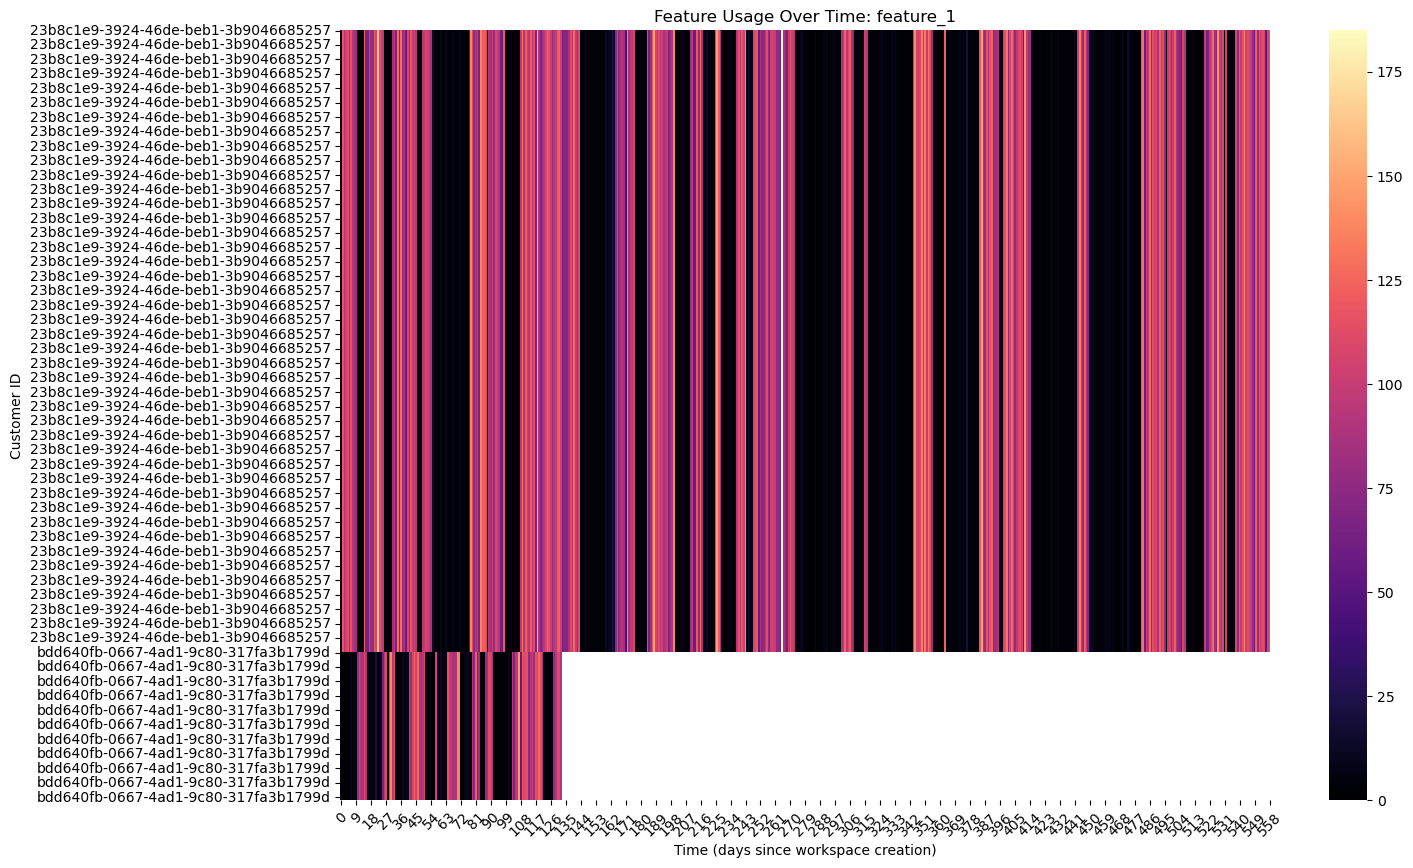

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def feature_usage_heatmap(data, feature):
    # Pivot the data to get a matrix where rows are customer_ids and columns are observation_dates
    heatmap_data = data.pivot(index='customer_id', columns='time', values=feature)
    
    # Sort by workspace_creation_date for a better visualization
    heatmap_data = heatmap_data.loc[data.set_index('customer_id').sort_values('workspace_creation_date').index]
    
    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap='magma', cbar=True, linewidths=0.0)
    
    # Set plot labels and title
    plt.xlabel('Time (days since workspace creation)')
    plt.ylabel('Customer ID')
    plt.title(f'Feature Usage Over Time: {feature}')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.show()


# Create the heatmap for a specific feature (e.g., 'feature_2')
feature_usage_heatmap(data, 'feature_1')

## Hidden Markov Model

### Generative model

In [18]:
import torch
import torch.distributions as dist
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Generative model with flat categorical priors
def generative_model(num_states=2, num_modalities=10):
    state_prior = dist.Categorical(torch.ones(num_states) / num_states)
    transition_prior = torch.ones((num_states, num_states)) / num_states
    
    mu_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0))
    sigma_prior = dist.Gamma(torch.tensor(1.0), torch.tensor(1.0))
    
    mu_params = mu_prior.sample((num_states, num_modalities))
    sigma_params = sigma_prior.sample((num_states, num_modalities))
    
    observation_model = []
    for state in range(num_states):
        state_distributions = [dist.Normal(mu, sigma) for mu, sigma in zip(mu_params[state], sigma_params[state])]
        observation_model.append(state_distributions)
    
    return state_prior, transition_prior, observation_model

# Variational distribution initialization
def variational_distribution(sequence_length, num_states, num_modalities):
    variational_params_x = torch.nn.Parameter(torch.ones(sequence_length, num_states) / num_states)
    
    mu_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0))
    sigma_prior = dist.Gamma(torch.tensor(1.0), torch.tensor(1.0))
    
    variational_mu = torch.nn.Parameter(mu_prior.sample((num_states, num_modalities)))
    variational_sigma = torch.nn.Parameter(sigma_prior.sample((num_states, num_modalities)))
    
    variational_transition_params = torch.nn.Parameter(torch.ones((num_states, num_states)) / num_states)
    
    return variational_params_x, variational_mu, variational_sigma, variational_transition_params

def calculate_elbo(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params):
    sequence_length, num_modalities = data.shape
    num_states = variational_params_x.shape[1]
    
    expected_log_prior = 0
    expected_log_likelihood = 0
    entropy = 0
    kl_divergence = 0

    ''' ELBO of the hidden states '''
    for t in range(sequence_length):
        for s in range(num_states):
            # Expected log prior
            log_prior = torch.log(state_prior.probs[s])
            if t > 0:
                previous_state = variational_params_x[t-1].argmax().item()
                log_prior += torch.log(variational_transition_params[previous_state, s])

            # Expected log likelihood
            log_likelihood = 0
            for m in range(num_modalities):
                log_likelihood += dist.Normal(variational_mu[s, m], variational_sigma[s, m]).log_prob(data[t, m])
            
            # Update expected log prior and log likelihood
            expected_log_prior += variational_params_x[t, s] * log_prior
            expected_log_likelihood += variational_params_x[t, s] * log_likelihood
        
        # Entropy 
        entropy += dist.Categorical(probs=variational_params_x[t]).entropy()

        # KL Divergence for state estimates
        kl_divergence += variational_params_x[t, s] * torch.log(variational_params_x[t, s] / state_prior.probs[s])

    ''' ELBO of the parameters (emissions and transition model) '''
    # Expected log joint (emissions)
    for s in range(num_states):
        for m in range(num_modalities):
            log_prior_mu = dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)).log_prob(variational_mu[s, m])
            log_prior_sigma = dist.Gamma(torch.tensor(1.0), torch.tensor(1.0)).log_prob(variational_sigma[s, m])
            expected_log_prior += log_prior_mu + log_prior_sigma

    # Expected log joint (transitions)
    for i in range(num_states):
        for j in range(num_states):
            expected_log_prior += variational_transition_params[i, j] * torch.log(transition_prior[i, j])

    # Entropy (emissions)
    entropy += torch.sum(0.5 * torch.log(2 * torch.pi * variational_sigma**2) + 0.5)

    # Entropy (transitions)
    entropy += torch.sum(variational_transition_params * torch.log(variational_transition_params))

    # KL Divergence (emissions)
    for s in range(num_states):
        for m in range(num_modalities):
            kl_divergence += dist.kl_divergence(dist.LogNormal(variational_mu[s, m], variational_sigma[s, m]),
                                                dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
            kl_divergence += dist.kl_divergence(dist.Gamma(variational_sigma[s, m], torch.tensor(1.0)),
                                                dist.Gamma(torch.tensor(1.0), torch.tensor(1.0)))

    # KL Divergence (transitions)
    kl_divergence += torch.sum(variational_transition_params * torch.log(variational_transition_params / transition_prior))


    '''Total ELBO Calculations'''
    elbo1 = expected_log_prior + expected_log_likelihood + entropy
    elbo2 = expected_log_likelihood - kl_divergence
    print(f'ELBO delta: {(elbo2 / elbo1 - 1):.1%}')
    return elbo1, elbo2

# E Step (state estimation)
def e_step(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params, optimizer_x):
    optimizer_x.zero_grad()
    elbo1, elbo2 = calculate_elbo(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params)
    vfe = -elbo1  # Use elbo1 for free energy
    loss = vfe
    print(f"E-Step Free energy: {vfe:,.0f}")
    loss.backward()
    optimizer_x.step()
    with torch.no_grad():
        variational_params_x.data = variational_params_x.data.softmax(dim=-1)

# M Step (Parameter estimation)
def m_step(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params, optimizer_theta):
    optimizer_theta.zero_grad()
    elbo1, elbo2 = calculate_elbo(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params)
    vfe = -elbo1  # Use elbo1 for free energy
    loss = vfe
    print(f"M-Step Free energy: {vfe:,.0f}")
    loss.backward()
    optimizer_theta.step()
    with torch.no_grad():
        variational_mu.data = variational_mu.data
        variational_sigma.data = variational_sigma.data
        variational_transition_params.data = variational_transition_params.data.softmax(dim=-1)  # Ensure transition probabilities sum to 1

# VBEM function without mini-batching
def vbem(data, num_states=2, num_modalities=10, num_iterations=1000, lr=0.01):
    sequence_length, num_modalities = data.shape

    state_prior, transition_prior, observation_model = generative_model(num_states, num_modalities)
    variational_params_x, variational_mu, variational_sigma, variational_transition_params = variational_distribution(sequence_length, num_states, num_modalities)

    optimizer_x = Adam([variational_params_x], lr=lr)
    optimizer_theta = Adam([variational_mu, variational_sigma, variational_transition_params], lr=lr)

    for iteration in range(num_iterations):
        print()
        print(f'Iteration {iteration}')
        e_step(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params, optimizer_x)
        m_step(data, state_prior, transition_prior, observation_model, variational_params_x, variational_mu, variational_sigma, variational_transition_params, optimizer_theta)

    return variational_params_x, variational_mu, variational_sigma, variational_transition_params, observation_model

# Fit VBEM model to each customer
def fit_vbem_to_customers(customer_data, num_states=2, num_iterations=1000, lr=0.1):
    results = {}
    for customer_id, group in customer_data.groupby('customer_id'):
        features = group.sort_values('time')[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
                                              'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']].values
        data_tensor = torch.tensor(features, dtype=torch.float32)
        variational_params_x, variational_mu, variational_sigma, variational_transition_params, observation_model = vbem(data_tensor, num_states, 10, num_iterations, lr)
        results[customer_id] = {
            'variational_params_x': variational_params_x,
            'variational_mu': variational_mu,  
            'variational_sigma': variational_sigma,
            'variational_transition_params': variational_transition_params,
            'observation_model': observation_model
        }
    return results

# Print the results for each customer
def print_results(results):
    for customer_id, result in results.items():
        print(f"Results for {customer_id}:\n")
        
        # Print variational state estimates
        print("Variational Parameters (state estimates):")
        print(result['variational_params_x'].detach().numpy())
        
        # Print optimized variational mu parameters
        print("\nVariational Mu Parameters:")
        print(result['variational_mu'].detach().numpy())
        
        # Print optimized variational sigma parameters
        print("\nVariational Sigma Parameters:")
        print(result['variational_sigma'].detach().numpy())
        
        # Print variational transition parameters
        print("\nVariational Transition Parameters:")
        print(result['variational_transition_params'].detach().numpy())
        
        print("\n" + "="*50 + "\n")

# Assuming you have a pandas DataFrame named 'data' with the necessary columns
results = fit_vbem_to_customers(data)
print_results(results)


Iteration 0
ELBO delta: -0.0%
E-Step Free energy: 1,271,468,032
ELBO delta: -0.0%
M-Step Free energy: 1,271,468,032

Iteration 1
ELBO delta: -0.0%
E-Step Free energy: 121,091,872
ELBO delta: -0.0%
M-Step Free energy: 121,385,072

Iteration 2
ELBO delta: -0.0%
E-Step Free energy: 59,608,928
ELBO delta: -0.0%
M-Step Free energy: 59,700,444

Iteration 3
ELBO delta: -0.0%
E-Step Free energy: 39,607,184
ELBO delta: -0.0%
M-Step Free energy: 39,642,392

Iteration 4
ELBO delta: -0.0%
E-Step Free energy: 29,882,874
ELBO delta: -0.0%
M-Step Free energy: 29,897,472

Iteration 5
ELBO delta: -0.0%
E-Step Free energy: 24,175,924
ELBO delta: -0.0%
M-Step Free energy: 24,181,936

Iteration 6
ELBO delta: -0.0%
E-Step Free energy: 20,439,116
ELBO delta: -0.0%
M-Step Free energy: 20,441,310

Iteration 7
ELBO delta: -0.0%
E-Step Free energy: 17,811,326
ELBO delta: -0.0%
M-Step Free energy: 17,811,756

Iteration 8
ELBO delta: -0.0%
E-Step Free energy: 15,868,606
ELBO delta: -0.0%
M-Step Free energy: 15,8